In [37]:
#! env/scripts/python.exe
# under python 3.9.4 in utf-8
# Anthony PARISOT/Clément VIDAL

In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

In [39]:
def interpolationLineaire(x, xa, xb, ya, yb):
    """Fait une interpolation linéaire pour trouver un résultat y entre deux valeur xa et xb """
    y = ya + (x - xa) * ((yb - ya)/(xb - xa))
    return y

def pareto(data):
    """Fonction de pareto qui affiche un graphique"""
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots()
    ax.bar(x,y,color="yellow")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()


def biplot(pca=[],x=None,y=None,components=[0,1],score=None,coeff=None,coeff_labels=None,score_labels=None,circle='T',bigdata=1000,cat=None,cmap="viridis",density=True):
    """Fonction qui permet d'afficher le cercle des corrélations"""


    if isinstance(pca,PCA)==True :
        coeff = np.transpose(pca.components_[components, :])
        score=  pca.fit_transform(x)[:,components]
        if isinstance(x,pd.DataFrame)==True :
            coeff_labels = list(x.columns)
    if score is not None : x = score

    if x.shape[1]>1 :

        xs = x[:,0]
        ys = x[:,1]

    else :

        xs = x
        ys = y

    if (len(xs) != len(ys)) : print("Warning ! x et y n'ont pas la même taille !")
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    #x_c = xs * scalex

    #y_c = ys * scaley
    temp = (xs - xs.min())
    x_c = temp / temp.max() * 2 - 1
    temp = (ys - ys.min())
    y_c = temp / temp.max() * 2 - 1
    data = pd.DataFrame({"x_c":x_c,"y_c":y_c})

    print("Attention : pour des facilités d'affichage, les données sont centrées-réduites")

    if cat is None : cat = [0]*len(xs)
    elif len(pd.Series(cat)) == 1 : cat = list(pd.Series(cat))*len(xs)
    elif len(pd.Series(cat)) != len(xs) : print("Warning ! Nombre anormal de catégories !")
    cat = pd.Series(cat).astype("category")
    fig = plt.figure(figsize=(6,6),facecolor='w') 
    ax = fig.add_subplot(111)
    # Affichage des points

    if (len(xs) < bigdata) :   
        ax.scatter(x_c,y_c, c = cat.cat.codes,cmap=cmap)
        if density==True : print("Warning ! Le mode density actif n'apparait que si BigData est paramétré.")

    # Affichage des nappes convexes (BigData)

    else :
        #color
        norm = mpl.colors.Normalize(vmin=0, vmax=(len(np.unique(cat.cat.codes)))) #-(len(np.unique(c)))
        cmap = cmap
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        if density==True :
            sns.set_style("white")
            sns.kdeplot(x="x_c",y="y_c",data=data)
            if len(np.unique(cat)) <= 1 :
                sns.kdeplot(x="x_c",y="y_c",data=data, cmap="Blues", shade=True, thresh= 0)

            else :
                for i in np.unique(cat) :
                    color_temp = m.to_rgba(i)
                    sns.kdeplot(x="x_c",y="y_c",data=data[cat==i], color=color_temp,
                                shade=True, thresh=0.25, alpha=0.25)     

        for cat_temp in cat.cat.codes.unique() :
            x_c_temp = [x_c[i] for i in range(len(x_c)) if (cat.cat.codes[i] == cat_temp)]
            y_c_temp = [y_c[i] for i in range(len(y_c)) if (cat.cat.codes[i] == cat_temp)]
            points = [ [ None ] * len(x_c_temp) ] * 2
            points = np.array(points)
            points = points.reshape(len(x_c_temp),2)
            points[:,0] = x_c_temp
            points[:,1] = y_c_temp
            hull = ConvexHull(points)
            temp = 0

            for simplex in hull.simplices:
                color_temp = m.to_rgba(cat_temp)
                plt.plot(points[simplex, 0], points[simplex, 1],color=color_temp)#, linestyle='dashed')#linewidth=2,color=cat)

                if (temp == 0) :
                     plt.xlim(-1,1)
                     plt.ylim(-1,1)
                     temp = temp+1

    if coeff is not None :
        if (circle == 'T') :
            x_circle = np.linspace(-1, 1, 100)
            y_circle = np.linspace(-1, 1, 100)
            X, Y = np.meshgrid(x_circle,y_circle)
            F = X**2 + Y**2 - 1.0
            #fig, ax = plt.subplots()
            plt.contour(X,Y,F,[0])
        n = coeff.shape[0]

        for i in range(n):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5,
                      head_width=0.05, head_length=0.05)

            if coeff_labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff_labels[i], color = 'g', ha = 'center', va = 'center')

        if score_labels is not None :
            for i in range(len(score_labels)) :
                temp_x = xs[i] * scalex
                temp_y = ys[i] * scaley
                plt.text(temp_x,temp_y,list(score_labels)[i])
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid(linestyle='--')
    plt.show()

In [40]:
dir = os.getcwd() + '\\data\\ACMB_Données vidal.xlsx' #Récupération du fichier de données
df_excel = pd.read_excel(dir, sheet_name=0)  

In [41]:
df_excel.head()

,Date,H10A,H11A,H12A,H1A,H2A,H4A,H6A,H7A,H8A,...,T11A,T12A,T1A,T2A,T4A,T6A,T7A,T8A,T9A,T10A
0,2011-04-12 14:15:16,0.000000,51.522690,51.363132,54.588825,50.522297,52.830837,45.194431,59.321507,60.030544,...,19.079998,19.279999,16.539997,14.939999,19.099998,19.840000,17.869999,18.340000,18.899998,19.059998
1,2011-04-12 14:30:16,0.000000,51.522690,51.330582,54.820488,48.370209,52.801228,45.563080,59.351727,60.060734,...,19.079998,19.270000,16.639999,15.289997,19.109997,19.730000,17.860001,18.340000,18.910000,19.070000
2,2011-04-12 14:45:16,546.830200,51.463135,51.269573,55.062439,47.855869,52.739185,44.786007,59.324669,60.063934,...,19.099998,19.279999,16.849998,15.899998,19.109997,19.889999,17.889999,18.359997,18.910000,19.090000
3,2011-04-12 15:00:16,638.621399,51.083607,50.743034,55.246273,47.542191,52.636280,39.539619,59.356472,60.070328,...,19.059998,19.079998,17.059998,15.889999,19.059998,18.759998,17.899998,18.399998,18.939999,19.070000
4,2011-04-12 15:15:16,701.131531,50.097813,49.626957,55.392223,48.189533,52.661697,41.100544,59.393024,60.075127,...,18.930000,18.919998,17.219997,14.629997,19.000000,19.639999,17.939999,18.430000,18.899998,19.039997


In [42]:
df_excel.shape #Dimension du dataframe

(337, 21)

In [43]:
df_excel.info() #Info sur les types de données

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    337 non-null    datetime64[ns]
 1   H10A    337 non-null    float64       
 2   H11A    337 non-null    float64       
 3   H12A    337 non-null    float64       
 4   H1A     337 non-null    float64       
 5   H2A     337 non-null    float64       
 6   H4A     337 non-null    float64       
 7   H6A     337 non-null    float64       
 8   H7A     337 non-null    float64       
 9   H8A     337 non-null    float64       
 10  H9A     337 non-null    float64       
 11  T11A    337 non-null    float64       
 12  T12A    337 non-null    float64       
 13  T1A     337 non-null    float64       
 14  T2A     337 non-null    float64       
 15  T4A     337 non-null    float64       
 16  T6A     337 non-null    float64       
 17  T7A     337 non-null    float64       
 18  T8A     33

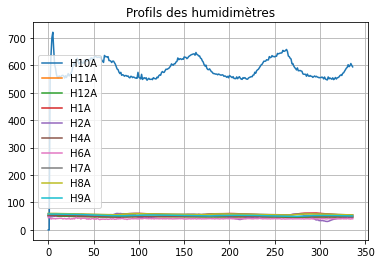

In [44]:
# Vérification des humiditmètres abérrant graphiquement

plt.plot(range(df_excel.shape[0]),df_excel.iloc[:,1:11])
plt.title('Profils des humidimètres')
plt.grid(True)
liste_name = []
for i in range(1,11):
    liste_name.append(df_excel.iloc[:,i].name)
plt.legend(liste_name)

In [45]:
# supression de la colonne H10A car elle comporte des données aberrantes

df_excel.pop("H10A")
df_excel.head()

,Date,H11A,H12A,H1A,H2A,H4A,H6A,H7A,H8A,H9A,T11A,T12A,T1A,T2A,T4A,T6A,T7A,T8A,T9A,T10A
0,2011-04-12 14:15:16,51.522690,51.363132,54.588825,50.522297,52.830837,45.194431,59.321507,60.030544,57.691025,19.079998,19.279999,16.539997,14.939999,19.099998,19.840000,17.869999,18.340000,18.899998,19.059998
1,2011-04-12 14:30:16,51.522690,51.330582,54.820488,48.370209,52.801228,45.563080,59.351727,60.060734,57.724583,19.079998,19.270000,16.639999,15.289997,19.109997,19.730000,17.860001,18.340000,18.910000,19.070000
2,2011-04-12 14:45:16,51.463135,51.269573,55.062439,47.855869,52.739185,44.786007,59.324669,60.063934,57.753536,19.099998,19.279999,16.849998,15.899998,19.109997,19.889999,17.889999,18.359997,18.910000,19.090000
3,2011-04-12 15:00:16,51.083607,50.743034,55.246273,47.542191,52.636280,39.539619,59.356472,60.070328,57.758144,19.059998,19.079998,17.059998,15.889999,19.059998,18.759998,17.899998,18.399998,18.939999,19.070000
4,2011-04-12 15:15:16,50.097813,49.626957,55.392223,48.189533,52.661697,41.100544,59.393024,60.075127,57.751999,18.930000,18.919998,17.219997,14.629997,19.000000,19.639999,17.939999,18.430000,18.899998,19.039997


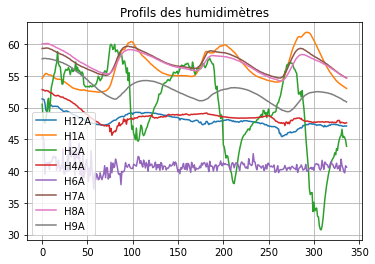

In [46]:
# Affichage graphique des humidimètres sans H10A

plt.plot(range(df_excel.shape[0]),df_excel.iloc[:,2:10])
plt.title('Profils des humidimètres')
plt.grid(True)
liste_name = []
for i in range(2,10):
    liste_name.append(df_excel.iloc[:,i].name)
plt.legend(liste_name)

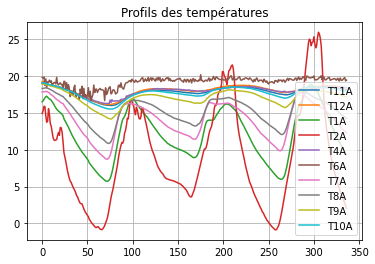

In [47]:
# Affichage graphique des températures

plt.plot(range(df_excel.shape[0]),df_excel.iloc[:,10:20])
plt.title('Profils des températures')
plt.grid(True)
liste_name = []
for i in range(10,20):
    liste_name.append(df_excel.iloc[:,i].name)
plt.legend(liste_name)

In [48]:
# Remplacement des valeurs abérantes dans les colonnes humidimètres
nbr_collums_H = 10
ecart_H = 4 # ecart en H% admis
index = 0 

for i in range(1, nbr_collums_H + 1, 1):
    df_test = df_excel.iloc[:,i]
    
    for j in range(0,df_test.shape[0]):
        val = df_test.iloc[j]
        if j == 0:
            val_end = df_test.iloc[j+1]
            ecart = abs(val - val_end)

            if val > 100 or val < 0 :
                df_test.iloc[j] = val_end
                index += 1
                
            elif ecart > ecart_H:
                df_test.iloc[j] = val_end
                index += 1
    

        elif j == df_test.shape[0]-1:
            val = df_test.iloc[j]
            val_start = df_test.iloc[j-1]
            ecart = abs(val - val_start)

            if val > 100 or val < 0 :
                df_test.iloc[j] = val_start
                index += 1
                
            elif ecart > ecart_H:
                df_test.iloc[j] = val_start
                index += 1

        else:
            val_start = df_test.iloc[j-1]
            val_end = df_test.iloc[j+1]

            ecart_low = abs(val - val_start)
            ecart_hight = abs(val - val_end)
            ecart = max(ecart_low, ecart_hight)

            if val > 100 or val < 0 :
                new = interpolationLineaire(j, j-1, j+1, val_start, val_end)
                index += 1
                df_test.iloc[j] = new
            elif ecart > ecart_H:
                new = interpolationLineaire(j, j-1, j+1, val_start, val_end)
                index += 1
                df_test.iloc[j] = new

    df_excel.iloc[:,i] = df_test
print("Nombre d'interpolation linéaire effectuée: ",index)

Nombre d'interpolation linéaire effectuée:  5


c:\Users\liber\OneDrive\Documents\Project code\Ingénieur ENSTIB\Traitement donnee\env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [49]:
# Remplacement des valeurs abérantes dans les colonnes températures

nbr_collums_T = 19
ecart_T = 2 # ecart en °C admis
index = 0

for i in range(nbr_collums_H + 1, nbr_collums_T + 1, 1):
    df_test = df_excel.iloc[:,i]
    
    for j in range(0,df_test.shape[0]):
        val = df_test.iloc[j]
        if j == 0:
            val_end = df_test.iloc[j+1]
            ecart = abs(val - val_end)

            if val > 50 or val < -10 :
                df_test.iloc[j] = val_end
                index += 1
                
            elif ecart > ecart_T:
                df_test.iloc[j] = val_end
                index += 1
    

        elif j == df_test.shape[0]-1:
            val = df_test.iloc[j]
            val_start = df_test.iloc[j-1]
            ecart = abs(val - val_start)

            if val > 50 or val < -10 :
                df_test.iloc[j] = val_start
                index += 1
                
            elif ecart > ecart_T:
                df_test.iloc[j] = val_start
                index += 1

        else:
            val_start = df_test.iloc[j-1]
            val_end = df_test.iloc[j+1]

            ecart_low = abs(val - val_start)
            ecart_hight = abs(val - val_end)
            ecart = max(ecart_low, ecart_hight)

            if val > 50 or val < -10 :
                new = interpolationLineaire(j, j-1, j+1, val_start, val_end)
                index += 1
                df_test.iloc[j] = new
            elif ecart > ecart_T:
                new = interpolationLineaire(j, j-1, j+1, val_start, val_end)
                index += 1
                df_test.iloc[j] = new

    df_excel.iloc[:,i] = df_test
print("Nombre d'interpolation linéaire effectuée: ",index)

Nombre d'interpolation linéaire effectuée:  4


[57.7626576  37.11844803 29.87108208 16.86542427 15.48202317 11.32935139
  6.97300641  4.78965105  4.5308856   3.8935801   3.07585598  1.83323969
  1.42231435  1.25552157  0.94057102  0.38678648  0.31555633  0.27384851
  0.20638511]
[5.22638567e-01 2.15817541e-01 1.39768412e-01 4.45555351e-02
 3.75459025e-02 2.01056082e-02 7.61635627e-03 3.59347700e-03
 3.21568363e-03 2.37468139e-03 1.48196899e-03 5.26436053e-04
 3.16882536e-04 2.46919549e-04 1.38576729e-04 2.34341768e-05
 1.55977125e-05 1.17470251e-05 6.67212018e-06]
[[-8.46204220e-02 -1.53248212e-01 -1.80458101e-01  1.51626561e-01
  -1.67811289e-01 -1.32505943e-01 -2.44971796e-01 -2.44033398e-01
  -1.58308356e-01 -2.70920267e-01 -2.52780300e-01 -2.90940864e-01
  -2.52525477e-01 -2.40578786e-01 -1.72672064e-01 -2.92497480e-01
  -3.06588068e-01 -2.99464659e-01 -2.84288392e-01]
 [ 4.40049990e-01  3.84742943e-01 -2.09316100e-01  2.82663669e-01
   3.29633145e-01  1.41807287e-01  1.16845011e-01  2.39728597e-01
   3.87293425e-01 -1.35449844

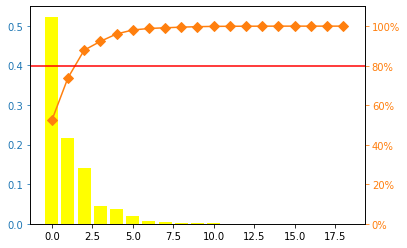

In [50]:
#ACP
cat_name = []
for i in range(1,20):
    cat_name.append(df_excel.iloc[:,i].name)
x = df_excel.iloc[:,1:20]
y = df_excel.iloc[:,0]
temp = x.sub(x.mean()) # Soustraire la moyenne de chaque colonne à chaque valeur : centrer les valeurs
x = temp.div(temp.std()) # Divisé les valeurs de la dataframe par l'écart-type de chaque colonne



mypca = PCA() # On paramètre ici pour ne garder que 3 composantes

# Modèle d'ACP
mypca.fit(x)

# Pourcentage de la variance expliquée par chacune des composantes sélectionnées.
print(mypca.singular_values_) # Valeurs de variance
print(mypca.explained_variance_ratio_) #  Pourcentages

# Axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données. Les composantes sont triées par variance expliquée.
print(mypca.components_) # 

# Résultats de l'ACP
data_sortie= mypca.fit_transform(x)

# Bruit estimé lié à la covariance
print(mypca.noise_variance_)


pareto(mypca.explained_variance_ratio_)

Dimension 17 et 18 :
Dimension T8A et T9A :
Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Le mode density actif n'apparait que si BigData est paramétré.


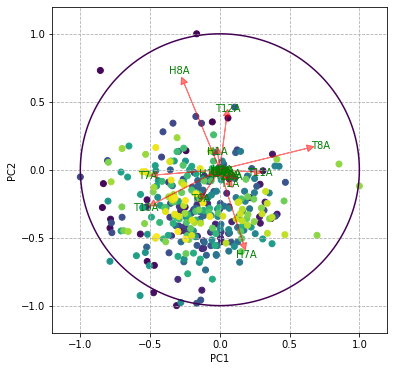

Dimension 17 et 19 :
Dimension T8A et T10A :
Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Le mode density actif n'apparait que si BigData est paramétré.


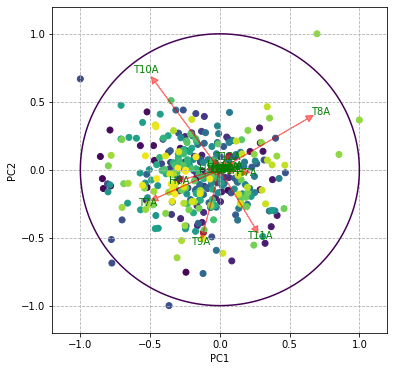

Dimension 18 et 19 :
Dimension T9A et T10A :
Attention : pour des facilités d'affichage, les données sont centrées-réduites
Warning ! Le mode density actif n'apparait que si BigData est paramétré.


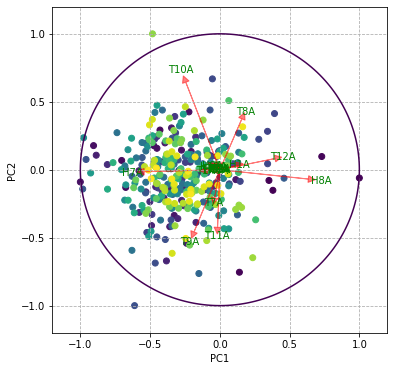

In [51]:
dim1 = 17 # entre 1 et 19
dim2 = 19

for i in range(dim1-1,dim2,1):
    for j in range(dim1-1,dim2,1):
        if i != j and i < j:
            print("Dimension {0} et {1} :".format(i+1 ,j+1))
            print("Dimension {0} et {1} :".format(df_excel.iloc[:,i+1].name, df_excel.iloc[:,j+1].name))
            biplot(mypca,x=x,cat=y,components=[i,j])
            plt.show()